## System RUL

In [1]:
import numpy as np
from pathlib import Path
import pandas as pd
import torch
import matplotlib.pyplot as plt

from src.models.particle_filter.core import ParticleFilterMLP, ParticleFilterModel
from src.models.rul_predictor import RULPredictor

from src.helpers.visualization import plot_rul_from_dataframe
from src.helpers.seed import set_global_seed

In [2]:
from src.models.degradation.normal import NormalDegradation as DegModel

## Task

In [3]:
data_name = "DS03"
filtered_data = True
degmodel_name = DegModel.name()
n_rep = 10
SEED = 42

pfnet_dir_name = 'net256x256x128x64x32leaky0.05'

## Hyper-Parameters

In [4]:
# PF parameters
n_particles = 1800

# PF-net architecture
hidden_dims=[256,256,128,64,32]
activation = torch.nn.LeakyReLU(0.05)

## Prediction settings
start_idx = 1
uncertainty_level = 0.95

## Plot resolution
t_grid = np.linspace(0.1, 100, 80) 
s_grid = np.linspace(0.0, 1.0, 60)

In [5]:
set_global_seed(SEED)
filtered_text = '_filtered' if filtered_data else ''

experiment_dir = Path('experiments')/data_name
degmodel_dir = experiment_dir/f'degradation{filtered_text}'/degmodel_name
pfnet_dir = degmodel_dir /'pf_performs'/pfnet_dir_name


## Load pf-models

In [6]:
hi_df = pd.read_csv(experiment_dir/f"hidata_dev{filtered_text}.csv")
dev_units = hi_df['unit'].astype(int).unique().tolist()
perform_names = [col for col in hi_df.columns if col not in ['unit','cycle','hs']]
del hi_df

dev_units 

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [7]:
pfs = {}
for perform_name in perform_names:
	# load pf-network
	net = ParticleFilterMLP(state_dim=DegModel.state_dim(), hidden_dims=hidden_dims,
                        activation=lambda : activation)
	ckpt = torch.load(pfnet_dir/perform_name/'checkpoint.pt', weights_only=False)
	net.load_state_dict(ckpt['model_state'])
	net = net.eval() 
	
	degmodels = []
	for unit in dev_units:
		best_model = DegModel()
		best_model.load_state_dict(
			torch.load(degmodel_dir/'states'/perform_name/f'unit_{unit}'/ "best_model.pt")
		)
		best_model
		degmodels.append(best_model)
  
	perform_pf = ParticleFilterModel(
									base_models = degmodels,
									net = net,
									n_particles=n_particles,
         							)
	pfs[perform_name] = perform_pf

## Create System RUL

In [8]:
rul_pred = RULPredictor(pf_models=pfs,current_obs=False)

## Import test data


In [9]:
hi_df = pd.read_csv(experiment_dir/f'hidata_test{filtered_text}.csv')
test_units = hi_df['unit'].astype(int).unique().tolist()
test_units

[10, 11, 12, 13, 14, 15]

In [10]:
performs = {name: 
    {unit: hi_df[hi_df['unit']==unit][name].values for unit in test_units} 
    for name in perform_names
}
time = {unit: hi_df[hi_df['unit']==unit]['cycle'].values for unit in test_units}
onsets = {unit: hi_df[(hi_df['unit']==unit) & (hi_df['hs']==0)]['cycle'].values[0] for unit in test_units}

del hi_df['hs']

## Prepare data

In [11]:
test_data = {}
for name, perform_units in performs.items():
    test_perform_data = {}
    for unit in test_units:
        t_data = time[unit]
        s_data = perform_units[unit]
        test_perform_data[unit]=torch.tensor(np.stack([t_data, s_data],axis=1),dtype=torch.float32)
    test_data[name]=test_perform_data

## System RUL

In [ ]:
preds:list[pd.DataFrame] = []  

for rep in range(n_rep):
    print(f"Starting repetition {rep+1}/{n_rep}...")
    rul_pred.reset()
    for test_unit in test_units:
        print(f"Processing unit {test_unit}...")
        s_data = {name: performs[name][test_unit] for name in perform_names}
        t_data = time[test_unit]
        eol_time = time[test_unit][-1]
     
        rul_pred.predict(
                t_data=t_data,
                s_data=s_data,
                start_idx=start_idx,
            )
        # Collect predictions
        df = rul_pred.history_to_dataframe()
        df["rep"] = rep 
        df["unit"] = test_unit
        df["true_rul"] = np.maximum(eol_time - df['time'], 0.0)
        preds.append(df)
    
preds_df = pd.concat(preds, ignore_index=True)
preds_df.to_csv(pfnet_dir / f"rul_test_predictions_rep{n_rep}.csv", index=False)


Starting repetition 1/10...
Processing unit 10...
Processing unit 11...
Processing unit 12...
Processing unit 13...
Processing unit 14...
Processing unit 15...
Starting repetition 2/10...
Processing unit 10...
Processing unit 11...
Processing unit 12...


# Plot final RUL predictions

In [ ]:
df_preds= pd.read_csv(pfnet_dir / f"rul_test_predictions_rep{n_rep}.csv")

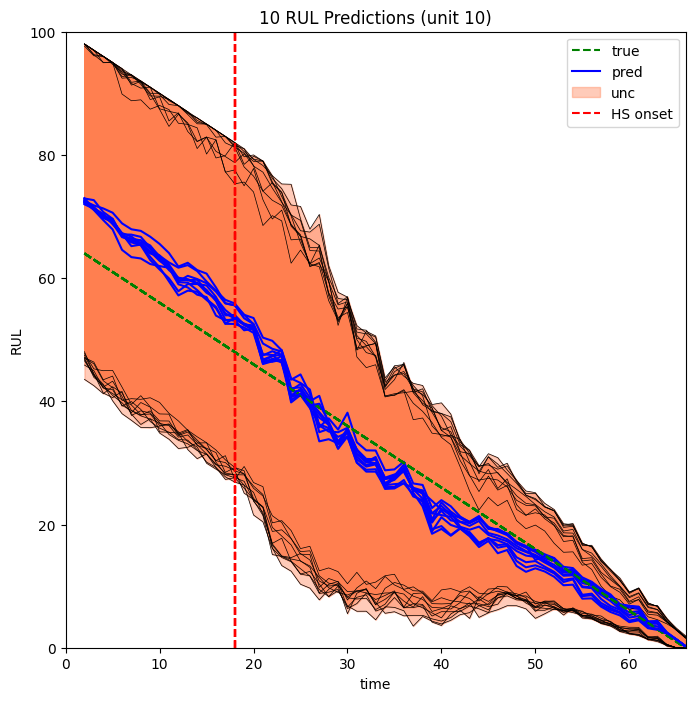

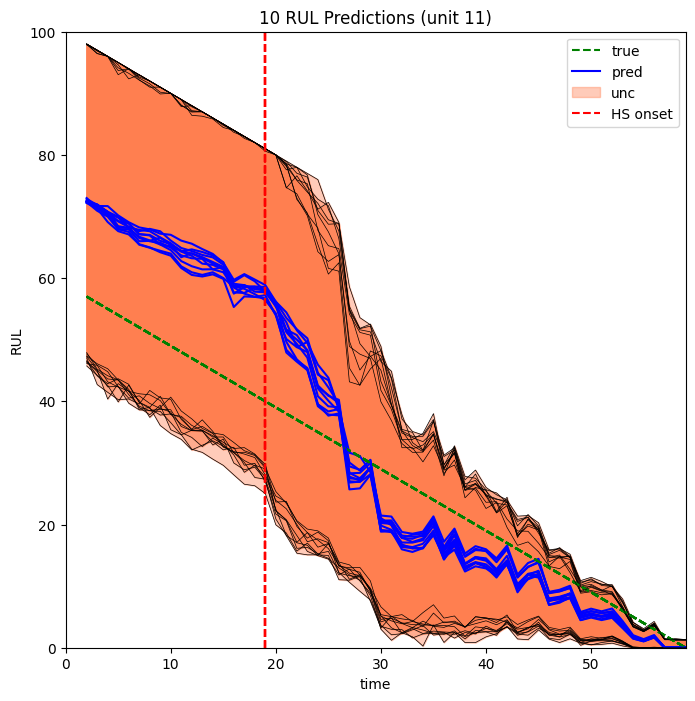

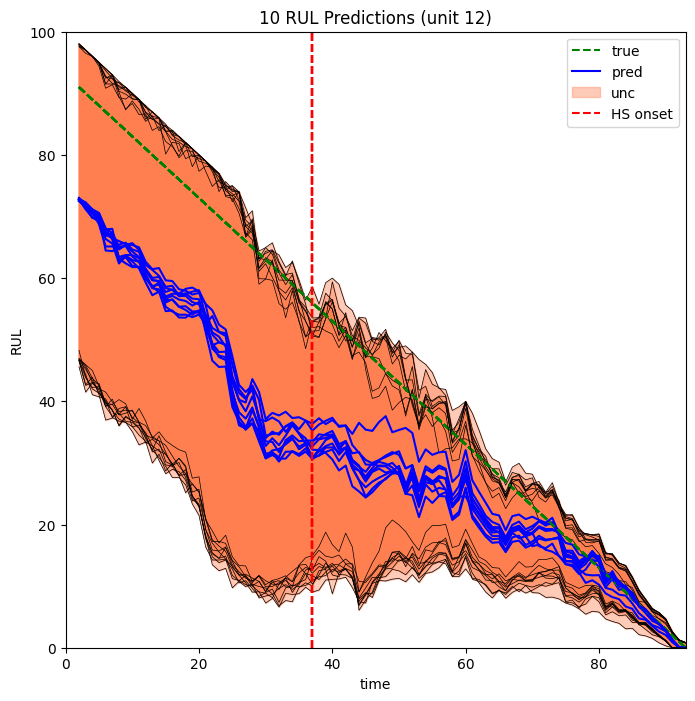

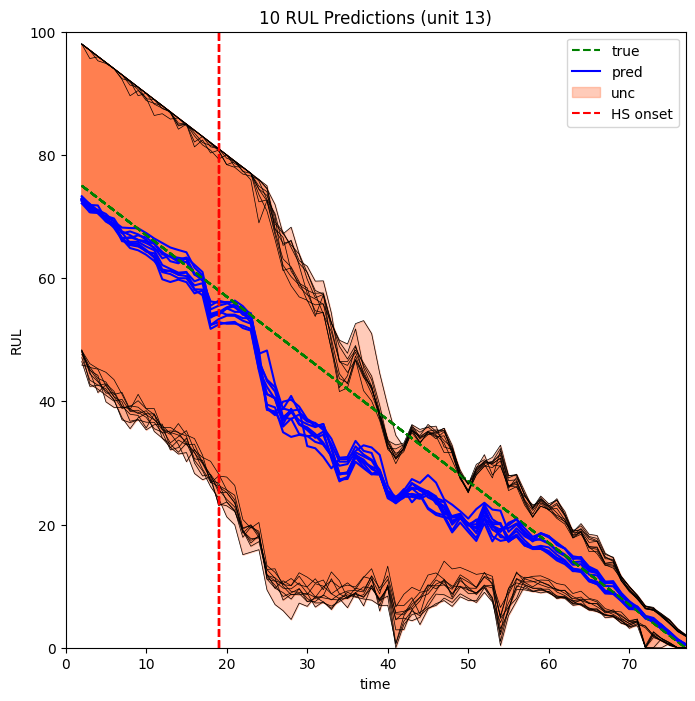

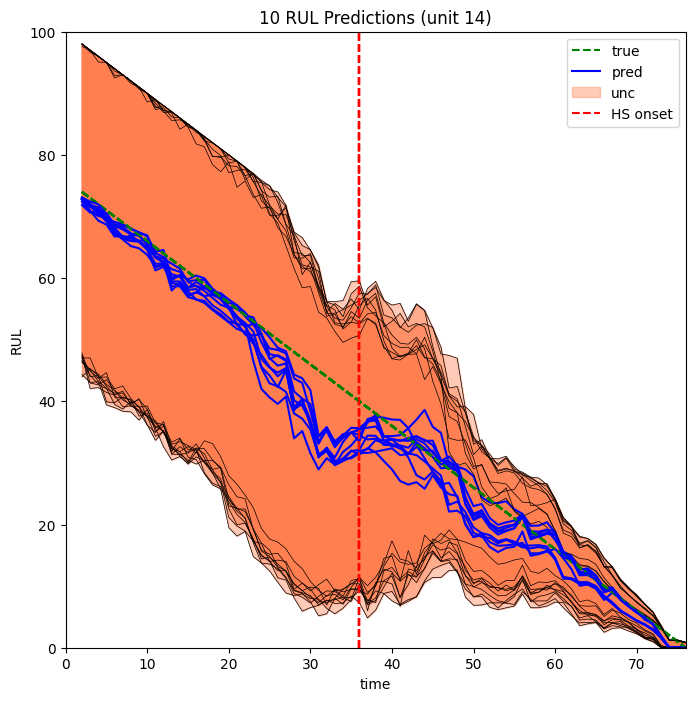

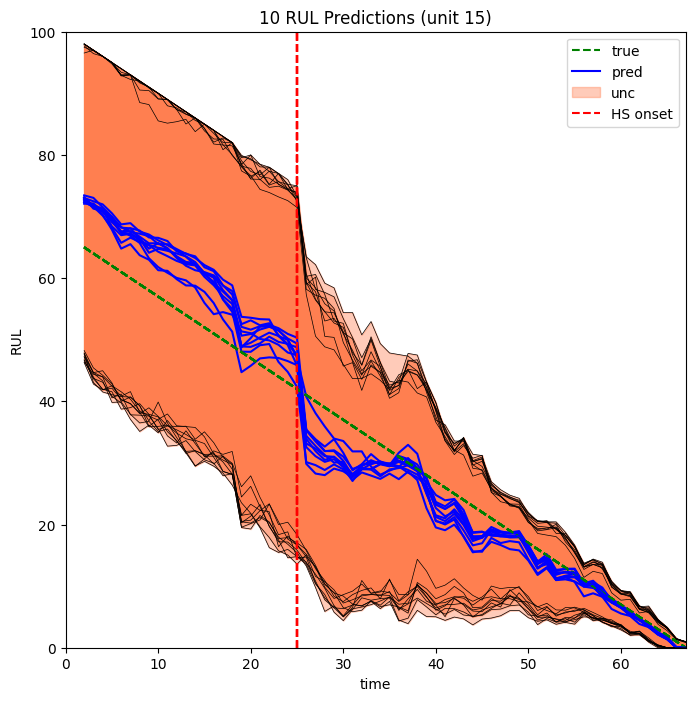

In [ ]:
for unit in test_units:
	fig, ax = plt.subplots(figsize=(8, 8))
	for rep in range(n_rep):
		df = df_preds[(df_preds['unit']==unit) & (df_preds['rep']==rep)]
		eol_time = df['time'].iloc[-1]
		plot_rul_from_dataframe(ax=ax, df=df,t_max=eol_time,
				title=f"{n_rep} RUL Predictions (unit {unit})", show_legend=False if rep else True)
		ax.vlines(onsets[unit], ymin=0, ymax=100, colors='red', linestyles='dashed', label='HS onset' if rep==0 else None)
	ax.legend()
	fig.savefig(pfnet_dir / f'rul_test_eval{unit}_rep{n_rep}.png')

## inal RUL Mean Prediction

In [ ]:
df_preds = df_preds.groupby(["unit", "time"], as_index=False).mean()

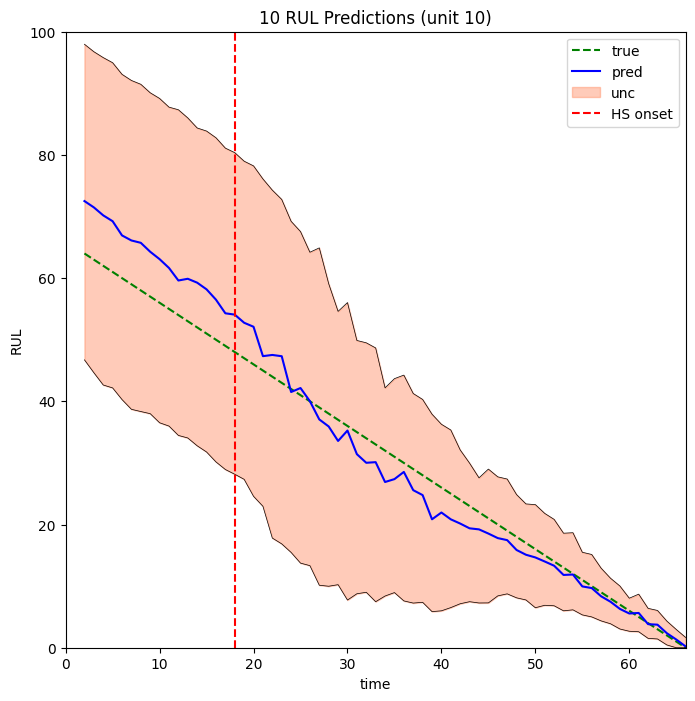

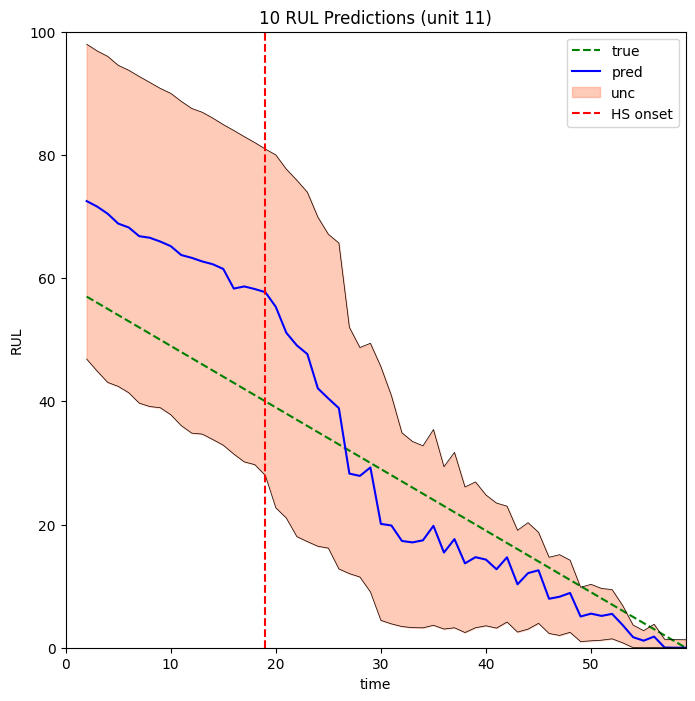

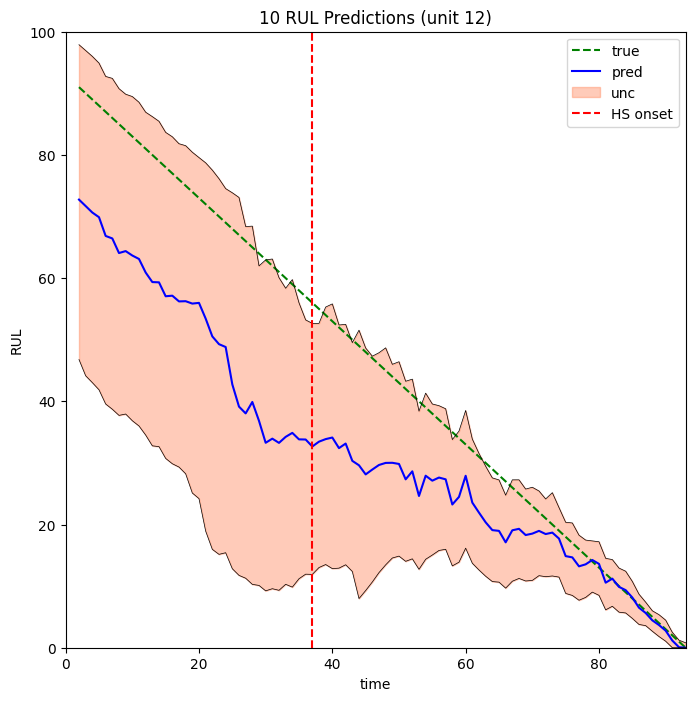

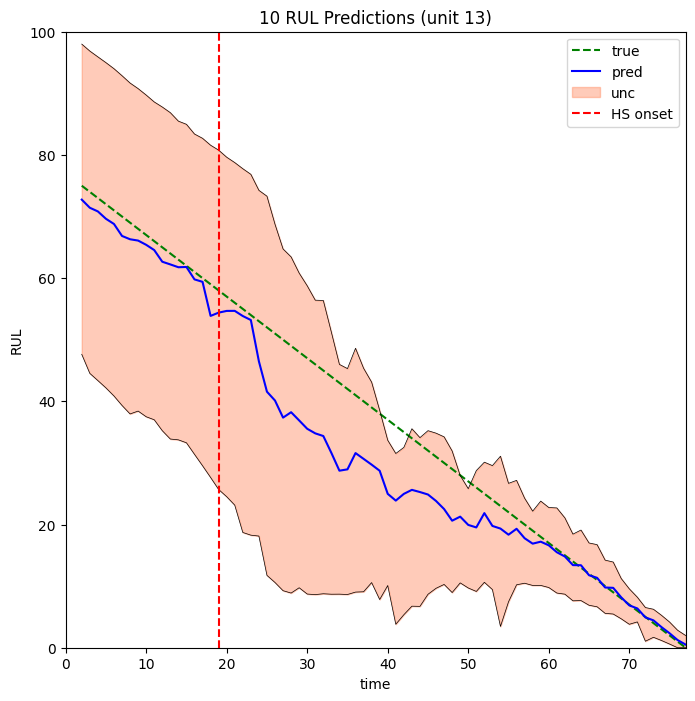

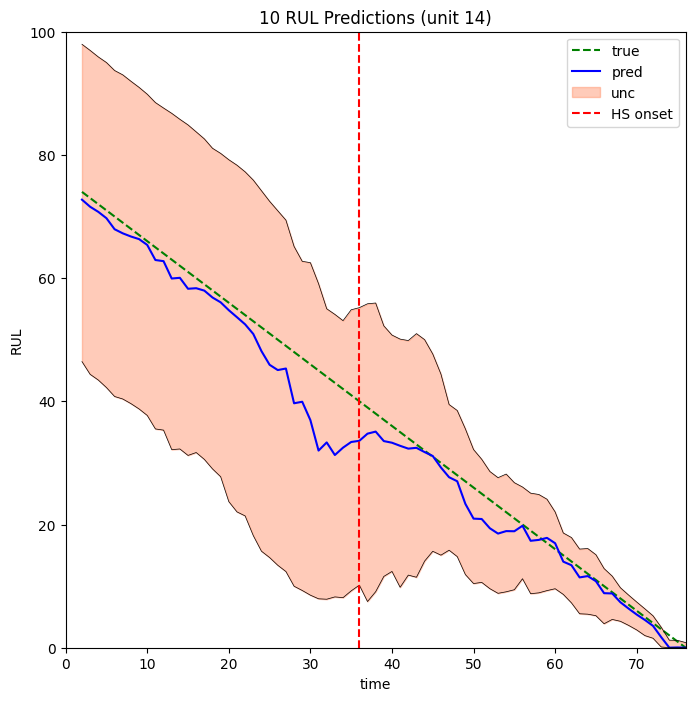

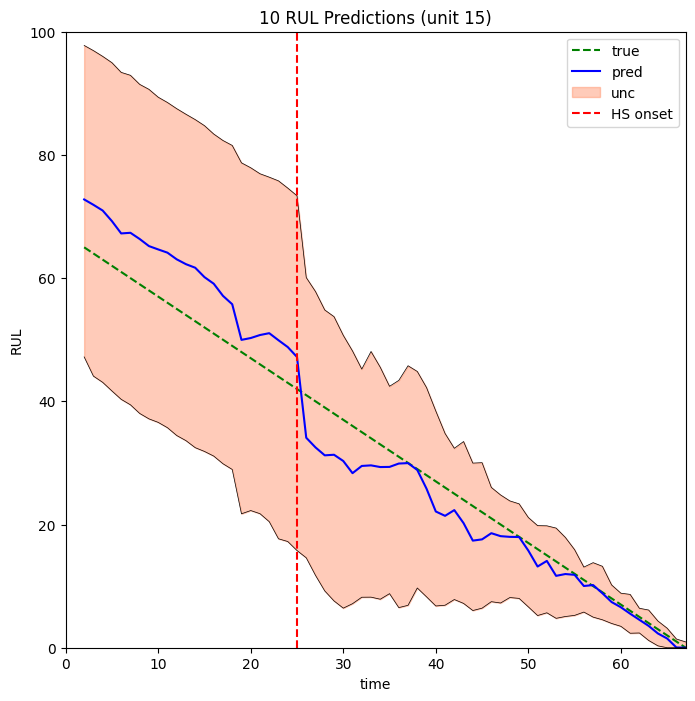

In [ ]:
df_preds = df_preds.groupby(["unit", "time"], as_index=False).mean()
for unit in test_units:
    fig, ax = plt.subplots(figsize=(8, 8))
    df = df_preds[df_preds['unit']==unit]
    eol_time = df['time'].iloc[-1]
    plot_rul_from_dataframe(ax=ax, df=df,t_max=eol_time,
            title=f"{n_rep} RUL Predictions (unit {unit})", show_legend= True)
    ax.vlines(onsets[unit], ymin=0, ymax=100, colors='red', linestyles='dashed', label='HS onset')
    ax.legend()
    fig.savefig(pfnet_dir / f'rul_test_eval{unit}_rep{n_rep}.png')
 